A Carteira 4Fundos DEF é composta por:

    * 15% Fidelity Global Cnsmr Inds A-Dis-EUR LU0114721508
    * 15% GS Glb SmCp CORE® Eq E EUR Acc Close LU0245181838
    * 15% M&G Optimal Income Euro A-H Acc GB00B1VMCY93
    * 55% PIMCO GIS Global Bond E Acc EUR H IE00B11XZ103

A Carteira 4Fundos EW é composta por:

    * 25% Fidelity Global Cnsmr Inds A-Dis-EUR LU0114721508
    * 25% GS Glb SmCp CORE® Eq E EUR Acc Close LU0245181838
    * 25% M&G Optimal Income Euro A-H Acc GB00B1VMCY93
    * 25% PIMCO GIS Global Bond E Acc EUR H IE00B11XZ103

In [12]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import plotly.plotly as py
import plotly

from matplotlib.ticker import FuncFormatter
from pandas.tseries.offsets import BDay
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Setting pandas dataframe display options
pd.set_option('display.width', 800)
pd.set_option('max_colwidth', 800)
pd.set_option("display.max_rows", 20)

# Set matplotlib style
plt.style.use('seaborn')

# Set plotly offline
init_notebook_mode(connected=True)

In [14]:
%%capture
import cufflinks as cf
cf.go_offline()

In [15]:
#### Functions ####
def compute_drawdowns(dataframe):
    """
    Function to compute drawdowns of a timeseries
    """
    return (dataframe / dataframe.cummax() -1) * 100

In [16]:
# Downloading funds and creating quotes and returns dataframes
Begin = "2015-01-02"
# End = '2017-08-20' # Só activas se quiseres que acabe num dia especifíco 

MSid = ['F0GBR04EAN', 'F000000FH0', 'F0000007LD', "F0GBR06T61"]
Nomes = ['FCI','GS_SC', 'MG_OI', 'PimcoGB']
fundos = pd.DataFrame()

# Conversão de datetime
conv = time.strptime(Begin,"%Y-%m-%d") 
start_date = time.strftime("%m/%d/%Y",conv)

# Download
for ticker in MSid:
    url = "https://lt.morningstar.com/api/rest.svc/timeseries_price/okhysb8aoh?id=" + str(ticker) + "&currencyId=BAS&idtype=Morningstar&frequency=daily&startDate=" + start_date + "&outputType=CSV"
    fundo = pd.read_csv(url, sep = ";" , index_col = 'date', parse_dates = True)
    fundo =  fundo.drop('Unnamed: 2', 1)
    fundos = fundos.merge(fundo, left_index = True, right_index = True, how='outer')
    
fundos.columns = Nomes
fundos = fundos.fillna(method='ffill')

# Filtering dataframe from Begin to END
# fundos = fundos.loc[:End] # Só activas se quiseres que acabe num dia especifíco

In [17]:
#### Normalization to 100 ####
fundos_norm = fundos.div(fundos.iloc[0]).mul(100)

In [18]:
fundos_norm.iplot(kind='scatter',yTitle='Valor por cada 100€ investidos', title='Performance dos fundos')

In [19]:
### weights ####
weights1 = np.array([0.15, 0.15, 0.15, 0.55])
weights2 = np.array([0.25, 0.25, 0.25, 0.25])

#### Fazer um dataframe vazio ####
novos_portfolios = fundos.copy().drop(fundos[:len(fundos.columns) - 1], axis=1)

### Calculate Portfolio value with linear algebra ####
novos_portfolios['4Fundos DEF'] = np.dot(fundos_norm, weights1) # weights1 * quotes1
novos_portfolios['4Fundos EW']  = np.dot(fundos_norm, weights2) # weights2 * quotes2

In [20]:
novos_portfolios.iplot(kind='scatter',yTitle='Valor por cada 100€ investidos', title='4Fundos DEF vs 4Fundos EW')

In [21]:
#### Computing Drawdowns ####
DD = round(compute_drawdowns(novos_portfolios), 2)

DD.iplot(kind='scatter', title='Drawdown dos portfolios', yTitle='Percentagem')

In [22]:
#### Returns ####
returns = novos_portfolios.pct_change()

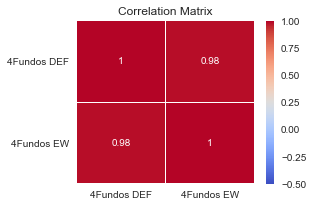

In [23]:
##### Correlation (bonus: Seaborn heatmap)####
Pcorr_matrix = returns.corr()

# Normal heatmap
fig, ax = plt.subplots()
fig.set_size_inches(4, 3) # 68%
sns.heatmap(Pcorr_matrix, annot = True, cmap = "coolwarm", linewidths=.2, vmin = -0.5)
plt.yticks(rotation=360)
plt.title('Correlation Matrix')
plt.show()

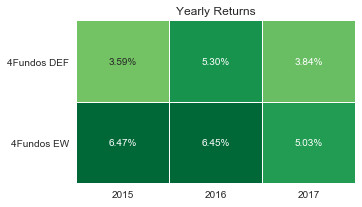

In [24]:
# Resampling to yearly (business year)
yearly_quotes = novos_portfolios.resample('BA').last()

# Adding first quote (only if start is in the middle of the year)
yearly_quotes = pd.concat([novos_portfolios.first('D'), yearly_quotes])

# Returns ### Falta trabalho para automatizar #####
yearly_returns = yearly_quotes.pct_change().mul(100).transpose().iloc[:, 1:]
yearly_returns.columns = [np.arange(2015, 2018)]

# Yearly returns heatmap
fig, ax = plt.subplots()
fig.set_size_inches(5, 3) # 68%
heatmap = sns.heatmap(yearly_returns, annot=True, cmap="RdYlGn", linewidths=.2, fmt=".2f", cbar=False, center=0)
for t in heatmap.texts: t.set_text(t.get_text() + "%")
plt.title('Yearly Returns')
plt.yticks(rotation=360)
plt.show()

** Notes: ** Portfolios without rebalancing